In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [28]:
data_complete = pd.read_csv('./super_data.csv')
data = data_complete[data_complete.columns[2:]].drop(['YEAR'], axis=1)
data['PH'] = data['PH'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4566 entries, 0 to 4565
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PH      4559 non-null   float64
 1   EC      4561 non-null   float64
 2   ALK     4559 non-null   float64
 3   SO4     4559 non-null   float64
 4   CO3     4554 non-null   float64
 5   F       4559 non-null   float64
 6   MG      4559 non-null   float64
 7   HCO3    4559 non-null   float64
 8   TDS     4559 non-null   float64
 9   NO3     4559 non-null   float64
 10  TH      4558 non-null   float64
 11  CL      4559 non-null   float64
 12  NA      4558 non-null   float64
 13  CA      4558 non-null   float64
 14  K       4558 non-null   float64
dtypes: float64(15)
memory usage: 535.2 KB


## :sparkles: CCME-WQI

In [29]:
drinking_water_range = {
    # "Component": [Acceptable Limit, Permissible Limit in absence of alternative source]
    "PH": [6.5, 8.5], #
    "EC": [0, 1500], #
    "TDS": [500, 2000], #
    "ALK": [200, 600], #
    "TH": [200, 600], #
    "CL": [250, 1000], #
    "CA": [75, 200], #
    "MG": [30, 100], #
    "SO4": [200, 400], #
    "NO3": [0, 45], #
    "F": [1, 1.5], #
}

In [32]:
import numpy as np

features = drinking_water_range.keys()
total_number_of_features = len(features)

def calculate_F1(df, guideline_values):
    F1 = sum(1 for feature in features if df[feature] < guideline_values[feature][0] or df[feature] > guideline_values[feature][1])
    return (F1*100)/total_number_of_features


def calculate_F2(df, guideline_values):
    F2 = sum(1 for feature in features if df[feature] > guideline_values[feature][1])
    return (F2*100)/total_number_of_features


def calculate_F3(df, guideline_values):
    F3_list = []
    for feature in features:
        F3 = 0
        if df[feature] < guideline_values[feature][0]:
            F3 = (guideline_values[feature][0] - df[feature])/guideline_values[feature][0]
        elif df[feature] > guideline_values[feature][1]:
            F3 = (df[feature] - guideline_values[feature][1])/guideline_values[feature][1]
        F3_list.append(F3)
    nse = sum(F3_list)/len(features)
    return nse/(0.01*nse + 0.01)


def calculate_WQI(df, guideline_values):
    wqi_values = []
    for idx, row in df.iterrows():
        F1 = calculate_F1(df.iloc[idx], guideline_values)
        F2 = calculate_F2(df.iloc[idx], guideline_values)
        F3 = calculate_F3(df.iloc[idx], guideline_values)
        wqi = (np.sqrt(F1*F1 + F2*F2 + F3*F3) / 1.732)  # Dividing by 1.732 to reduce the value to 100
        wqi_values.append(wqi)
    return wqi_values


# Calculating WQI for each instance
wqi_values = calculate_WQI(data, drinking_water_range)
# Adding WQI values to DataFrame
results = pd.DataFrame()
results['CCME-WQI'] = wqi_values
results['CCME-WQI'] = results['CCME-WQI'].apply(lambda x: np.abs(100-x))

In [33]:
results['CCME-WQI']

0       61.555420
1       64.601738
2       69.023569
3       76.746451
4       29.843938
          ...    
4561    60.989717
4562    57.180425
4563    75.149894
4564    87.842858
4565    77.998531
Name: CCME-WQI, Length: 4566, dtype: float64

## :sparkles: WAWQI

In [34]:
constants = pd.DataFrame({
    'features':        ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG'],
    'standard_values': [8.5 , 300, 1000,  120, 300, 1.5, 250,  45,  250,  75,  30],
    'ideal_values':    [    7,  0,    0,    0,   0,   0,   0,   0,    0,   0,   0],
})

In [35]:
def calculate_K():
    return 1/(constants['standard_values'].sum())

def calculate_qi_wi(df):
    qn = pd.DataFrame()
    qi_wi = []
    Wn = calculate_unit_weight_of_nth_parameter()

    for col in constants['features']:
        v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
        s_value = constants[constants['features'] == col]['standard_values'].values[0]
        qn[col] = 100 * ((df[col] - v_ideal) / (s_value - v_ideal))

    for row in qn.iterrows():
        qi_wi.append((np.array(row[1])*Wn).sum())
    
    qn['qi_wi'] = qi_wi

    return qn

def calculate_unit_weight_of_nth_parameter():
    Wn = []
    K = calculate_K()
    for feature in features:
        Wn.append(K/constants[constants['features'] == feature]['standard_values'])
    constants['unit_weights'] = Wn
    return Wn

def calculate_wawqi(data):
    Wn = calculate_unit_weight_of_nth_parameter()
    qn = calculate_qi_wi(data)

    wawqi = qn['qi_wi'] / np.array(Wn).sum()
    return wawqi/100

wawqi = calculate_wawqi(data)

In [36]:
results['WAWQI'] = wawqi

In [37]:
results

,CCME-WQI,WAWQI
0,61.555420,38.644111
1,64.601738,8.988333
2,69.023569,22.555222
3,76.746451,14.035111
4,29.843938,103.398000
...,...,...
4561,60.989717,7.274778
4562,57.180425,34.582556
4563,75.149894,23.527667
4564,87.842858,15.582556


## :sparkles: EBWQI

In [42]:
from sklearn.preprocessing import MinMaxScaler

# data = data.drop(['DISTRICT','YEAR','LOCATION'], axis=1).reset_index(drop=True)
data = data.reset_index(drop=True)

scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data

,PH,EC,ALK,SO4,CO3,F,MG,HCO3,TDS,NO3,TH,CL,NA,CA,K
0,0.008383,0.088537,0.441708,0.122183,0.0,0.040625,0.012223,0.467816,0.087319,0.010625,0.051877,0.031796,0.125323,0.019608,0.000667
1,0.008221,0.014630,0.109195,0.029656,0.0,0.027500,0.002546,0.120295,0.013312,0.007500,0.017084,0.001481,0.016989,0.010893,0.028667
2,0.008647,0.047222,0.252874,0.019375,0.0,0.003125,0.018335,0.270489,0.045970,0.010000,0.064055,0.018675,0.050966,0.013072,0.061667
3,0.008521,0.027630,0.137931,0.021352,0.0,0.021875,0.007894,0.150193,0.026348,0.010625,0.036220,0.007569,0.025606,0.015251,0.008667
4,0.008434,0.268889,0.404762,0.189008,0.0,0.038750,0.055004,0.429124,0.267907,0.028125,0.234543,0.179096,0.361689,0.095861,0.055000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,0.008045,0.014222,0.051724,0.043100,0.0,0.001875,0.004838,0.060148,0.012925,0.002000,0.031001,0.004360,0.011449,0.019608,0.016667
4562,0.008434,0.081833,0.125616,0.137999,0.0,0.009750,0.028520,0.137531,0.080621,0.008125,0.121638,0.043478,0.087406,0.050109,0.028333
4563,0.008271,0.054481,0.084565,0.228153,0.0,0.011625,0.004329,0.094618,0.053222,0.020625,0.069274,0.023035,0.067709,0.069717,0.043333
4564,0.007957,0.027111,0.195402,0.025306,0.0,0.013000,0.009167,0.210341,0.025822,0.000194,0.071014,0.005553,0.015142,0.054466,0.030000


In [43]:
import numpy as np

# calculate entropy weight and information entropy for entropy water quality index
def information_entropy(df):
    # calculate information entropy
    information_entropy_arr = {}
    for i in range(len(df.columns)):
        p = df.iloc[:,i]/df.iloc[:,i].sum()
        entropy = - (p * np.log(p)/np.log(len(df))).sum()
        information_entropy_arr[df.columns.to_list()[i]] = entropy
    return information_entropy_arr

def entropy_weight(df):
    # calculate entropy weight
    information_entropy_arr_res = information_entropy(df)
    information_entropy_arr = np.array(list(information_entropy_arr_res.values()))
    # print(information_entropy_arr_res)
    information_entropy_arr_sum = np.sum(1 - information_entropy_arr)
    information_entropy_arr_res_df = pd.DataFrame({
        'features': list(information_entropy_arr_res.keys()),
        'information_entropy': list(information_entropy_arr_res.values())
    })
    # print(information_entropy_arr_res_df)
    information_entropy_arr_res_df['entropy_weights'] = (1 - information_entropy_arr_res_df['information_entropy'])/information_entropy_arr_sum
    # print(information_entropy_arr_res_df)
    return information_entropy_arr_res_df

entropy_weight_arr = entropy_weight(scaled_data[constants['features']])
entropy_weight_arr

,features,information_entropy,entropy_weights
0,PH,0.988699,0.020064
1,EC,0.950484,0.087912
2,TDS,0.947134,0.093858
3,ALK,0.980946,0.033829
4,TH,0.958217,0.074182
5,F,0.942822,0.101516
6,CL,0.899062,0.179207
7,NO3,0.922581,0.137451
8,SO4,0.953831,0.081969
9,CA,0.952911,0.083603


In [44]:
constants['weights'] = entropy_weight_arr['entropy_weights'].to_list()
constants

,features,standard_values,ideal_values,unit_weights,weights
0,PH,8.5,7,"0 0.000049 Name: standard_values, dtype: fl...",0.020064
1,EC,300.0,0,"1 0.000001 Name: standard_values, dtype: fl...",0.087912
2,TDS,1000.0,0,"2 4.201681e-07 Name: standard_values, dtype...",0.093858
3,ALK,120.0,0,"3 0.000004 Name: standard_values, dtype: fl...",0.033829
4,TH,300.0,0,"4 0.000001 Name: standard_values, dtype: fl...",0.074182
5,F,1.5,0,"6 0.000002 Name: standard_values, dtype: fl...",0.101516
6,CL,250.0,0,"9 0.000006 Name: standard_values, dtype: fl...",0.179207
7,NO3,45.0,0,"10 0.000014 Name: standard_values, dtype: f...",0.137451
8,SO4,250.0,0,"8 0.000002 Name: standard_values, dtype: fl...",0.081969
9,CA,75.0,0,"7 0.000009 Name: standard_values, dtype: fl...",0.083603


In [45]:
import numpy as np

qe = pd.DataFrame()
qi_wi = []

for col in constants['features']:
    # print('col = ', col)
    v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
    s_value = constants[constants['features'] == col]['standard_values'].values[0]
    # print(v_ideal, s_value)
    qe[col] = 100 * (data[col] - v_ideal) / (s_value - v_ideal)

for row in qe.iterrows():
    qi_wi.append((np.array(row[1])*constants['weights']).sum())

qe

,PH,EC,TDS,ALK,TH,F,CL,NO3,SO4,CA,MG
0,46.000000,1593.666667,320.3,916.666667,100.000000,216.666667,312.0,37.777778,108.0,53.333333,160.000000
1,37.333333,263.333333,52.9,241.666667,33.333333,146.666667,17.2,26.666667,14.4,32.000000,33.333333
2,60.000000,850.000000,170.9,533.333333,123.333333,16.666667,184.4,35.555556,4.0,37.333333,240.000000
3,53.333333,497.333333,100.0,300.000000,70.000000,116.666667,76.4,37.777778,6.0,42.666667,103.333333
4,48.666667,4840.000000,972.8,841.666667,450.000000,206.666667,1744.4,100.000000,175.6,240.000000,720.000000
...,...,...,...,...,...,...,...,...,...,...,...
4561,28.000000,256.000000,51.5,125.000000,60.000000,10.000000,45.2,7.111111,28.0,53.333333,63.333333
4562,48.666667,1473.000000,296.1,275.000000,233.666667,52.000000,425.6,28.888889,124.0,128.000000,373.333333
4563,40.000000,980.666667,197.1,191.666667,133.333333,62.000000,226.8,73.333333,215.2,176.000000,56.666667
4564,23.333333,488.000000,98.1,416.666667,136.666667,69.333333,56.8,0.688889,10.0,138.666667,120.000000


In [46]:
qe['qi_wi'] = qi_wi
results['EBWQI'] = qe['qi_wi'] / constants['weights'].sum()
results

,CCME-WQI,WAWQI,EBWQI
0,61.555420,38.644111,322.953062
1,64.601738,8.988333,68.551642
2,69.023569,22.555222,187.772599
3,76.746451,14.035111,115.300810
4,29.843938,103.398000,1038.036172
...,...,...,...
4561,60.989717,7.274778,60.166415
4562,57.180425,34.582556,331.010335
4563,75.149894,23.527667,217.290519
4564,87.842858,15.582556,119.304083


(0.0, 1000.0)

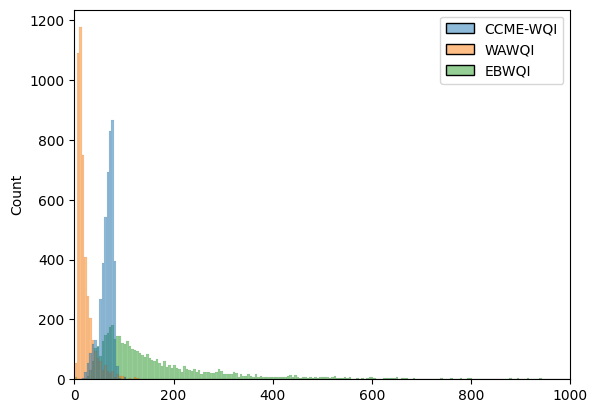

In [47]:
sns.histplot(results)
sns.set_palette('Pastel2')
plt.xlim(0, 1000)

In [48]:
results.to_csv("wqi_results.csv", index=False)

## Regression

In [56]:
# import all other regression models available in different libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

# import metrics to evaluate the models
from sklearn.model_selection import cross_val_score, KFold

In [57]:
# create a dictionary for model names and model objects

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Elastic Net': ElasticNet(),
    'K Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Support Vector Machine': SVR(),
    'Ada Boost': AdaBoostRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gaussian Process': GaussianProcessRegressor(),
    'Kernel Ridge': KernelRidge(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=False),
    'LightGBM': LGBMRegressor(),
    'Multi Layer Perceptron': MLPRegressor()
}

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def correlation_coefficient(observed, predicted):
    return np.corrcoef(observed, predicted)[0, 1]

def root_mean_square_error(observed, predicted):
    return np.sqrt(mean_squared_error(observed, predicted))

def nash_sutcliffe_efficiency(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    return 1 - (numerator / denominator)

def index_of_agreement(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((np.abs(predicted - mean_observed) +
                          np.abs(observed - mean_observed)) ** 2)
    return 1 - (numerator / denominator)

In [59]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

wqi = pd.concat([data, results], axis=1)
wqi = wqi.dropna()
features = ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG']

X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

# Create a dictionary to store results
results_dict = {'Model': [], 'Target': [], 'Metric': [], 'Metric Value': [], 'y_test': [], 'y_pred': []}

# Metrics to calculate
metrics = {
    'MSE': mean_squared_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error,
    'R2': r2_score,
    'NSE': lambda y_true, y_pred: 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
}

# Loop through models
for name, model in tqdm(models.items()):
    for target_name, target_train, target_test in [('WAWQI', y1_train, y1_test), ('EBWQI', y2_train, y2_test), ('CCME-WQI', y3_train, y3_test)]:
        for metric_name, metric_func in metrics.items():
            # Train the model
            model.fit(X_train, target_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Calculate the metric value
            metric_value = metric_func(target_test, y_pred)

            # Store results in the dictionary
            results_dict['Model'].append(name)
            results_dict['Target'].append(target_name)
            results_dict['Metric'].append(metric_name)
            results_dict['Metric Value'].append(metric_value)
            results_dict['y_test'].append(target_test)
            results_dict['y_pred'].append(y_pred)


# Create a DataFrame
regression_results_df = pd.DataFrame(results_dict)

# Pivot the DataFrame
comparison_df_reg = regression_results_df.pivot(index='Target', columns=['Metric','Model'], values='Metric Value')

# Print the comparison DataFrame
comparison_df_reg.style.background_gradient(cmap='Greens', axis=None)

 88%|████████▊ | 15/17 [03:13<00:46, 23.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 3640, number of used features: 11
[LightGBM] [Info] Start training from score 20.757104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 3640, number of used features: 11
[LightGBM] [Info] Start training from score 20.757104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 3640, number of used features: 11
[LightGBM] [Info] Start trai

100%|██████████| 17/17 [04:20<00:00, 15.30s/it]


Metric,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE
Model,Linear Regression,Linear Regression,Linear Regression,Linear Regression,Linear Regression,Ridge,Ridge,Ridge,Ridge,Ridge,Lasso,Lasso,Lasso,Lasso,Lasso,Elastic Net,Elastic Net,Elastic Net,Elastic Net,Elastic Net,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,Decision Tree,Decision Tree,Decision Tree,Decision Tree,Decision Tree,Support Vector Machine,Support Vector Machine,Support Vector Machine,Support Vector Machine,Support Vector Machine,Ada Boost,Ada Boost,Ada Boost,Ada Boost,Ada Boost,Gradient Boosting,Gradient Boosting,Gradient Boosting,Gradient Boosting,Gradient Boosting,Extra Trees,Extra Trees,Extra Trees,Extra Trees,Extra Trees,Random Forest,Random Forest,Random Forest,Random Forest,Random Forest,Gaussian Process,Gaussian Process,Gaussian Process,Gaussian Process,Gaussian Process,Kernel Ridge,Kernel Ridge,Kernel Ridge,Kernel Ridge,Kernel Ridge,XGBoost,XGBoost,XGBoost,XGBoost,XGBoost,CatBoost,CatBoost,CatBoost,CatBoost,CatBoost,LightGBM,LightGBM,LightGBM,LightGBM,LightGBM,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron
Target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCME-WQI,94.778842,9.735443,8.012470,0.471251,0.471251,94.437500,9.717896,7.994938,0.473155,0.473155,98.822613,9.940956,8.320894,0.448692,0.448692,98.468554,9.923132,8.323504,0.450667,0.450667,22.789966,4.773884,3.381878,0.872860,0.872860,16.737750,3.980921,2.256950,0.911333,0.902853,29.566027,5.437465,4.044078,0.835058,0.835058,21.773149,4.609871,3.711049,0.887239,0.875579,2.967943,1.719244,1.212343,0.983444,0.983407,11.781243,3.432736,2.344001,0.935823,0.933065,8.369657,2.875557,1.730067,0.952531,0.953235,141910.023430,376.709468,166.698035,-790.682598,-790.682598,4488.089258,66.993203,66.246029,-24.037993,-24.037993,3.016283,1.736745,1.037806,0.983173,0.983173,0.750227,0.866156,0.507994,0.995815,0.995815,2.100659,1.449365,0.875092,0.988281,0.988281,29.579512,5.487051,4.398053,0.849008,0.831026
EBWQI,0.000000,0.000000,0.000000,1.000000,1.000000,0.534017,0.730764,0.046282,0.999987,0.999987,13.345330,3.653126,1.753095,0.999678,0.999678,465.571677,21.577110,12.046178,0.988754,0.988754,1009.524206,31.773011,13.111890,0.975614,0.975614,697.905629,26.284142,12.219806,0.981881,0.983722,22506.534041,150.021779,39.338873,0.456326,0.456326,4279.281202,60.378529,47.617126,0.911927,0.911503,234.329525,15.328777,5.795910,0.994283,0.994238,413.770001,19.126239,6.662046,0.989494,0.991383,615.808134,24.106960,7.733473,0.986692,0.987237,36371.202104,190.712354,44.104691,0.121407,0.121407,35528.506747,188.490071,188.374667,0.141764,0.141764,858.591967,29.301740,8.322827,0.979260,0.979260,277.312738,16.652710,4.055806,0.993301,0.993301,1387.444417,37.248415,8.998455,0.966485,0.966485,21.475981,5.187916,4.731636,0.999384,0.999384
WAWQI,0.000000,0.000000,0.000000,1.000000,1.000000,0.006897,0.083049,0.006232,0.999982,0.999982,2.996738,1.731109,1.170718,0.992164,0.992164,5.780090,2.404182,1.529630,0.984887,0.984887,9.166602,3.027640,1.254902,0.976032,0.976032,9.151653,3.052457,1.417448,0.973558,0.972514,117.089318,10.820782,1.898468,0.693847,0.693847,29.069267,5.978507,4.274190,0.932654,0.929856,2.695466,1.662956,0.712532,0.992860,0.992907,3.942742,1.941939,0.764081,0.991028,0.990220,5.466029,2.332685,0.906397,0.985546,0.984593,350.634969,18.725249,4.418768,0.083195,0.083195,436.408337,20.890389,20.877568,-0.141076,-0.141076,8.212251,2.865703,0.785791,0.978527,0.978527,2.301330,1.517013,0.398921,0.993983,0.993983,14.518439,3.810307,1.033548,0.962039,0.962039,0.039235,0.2271

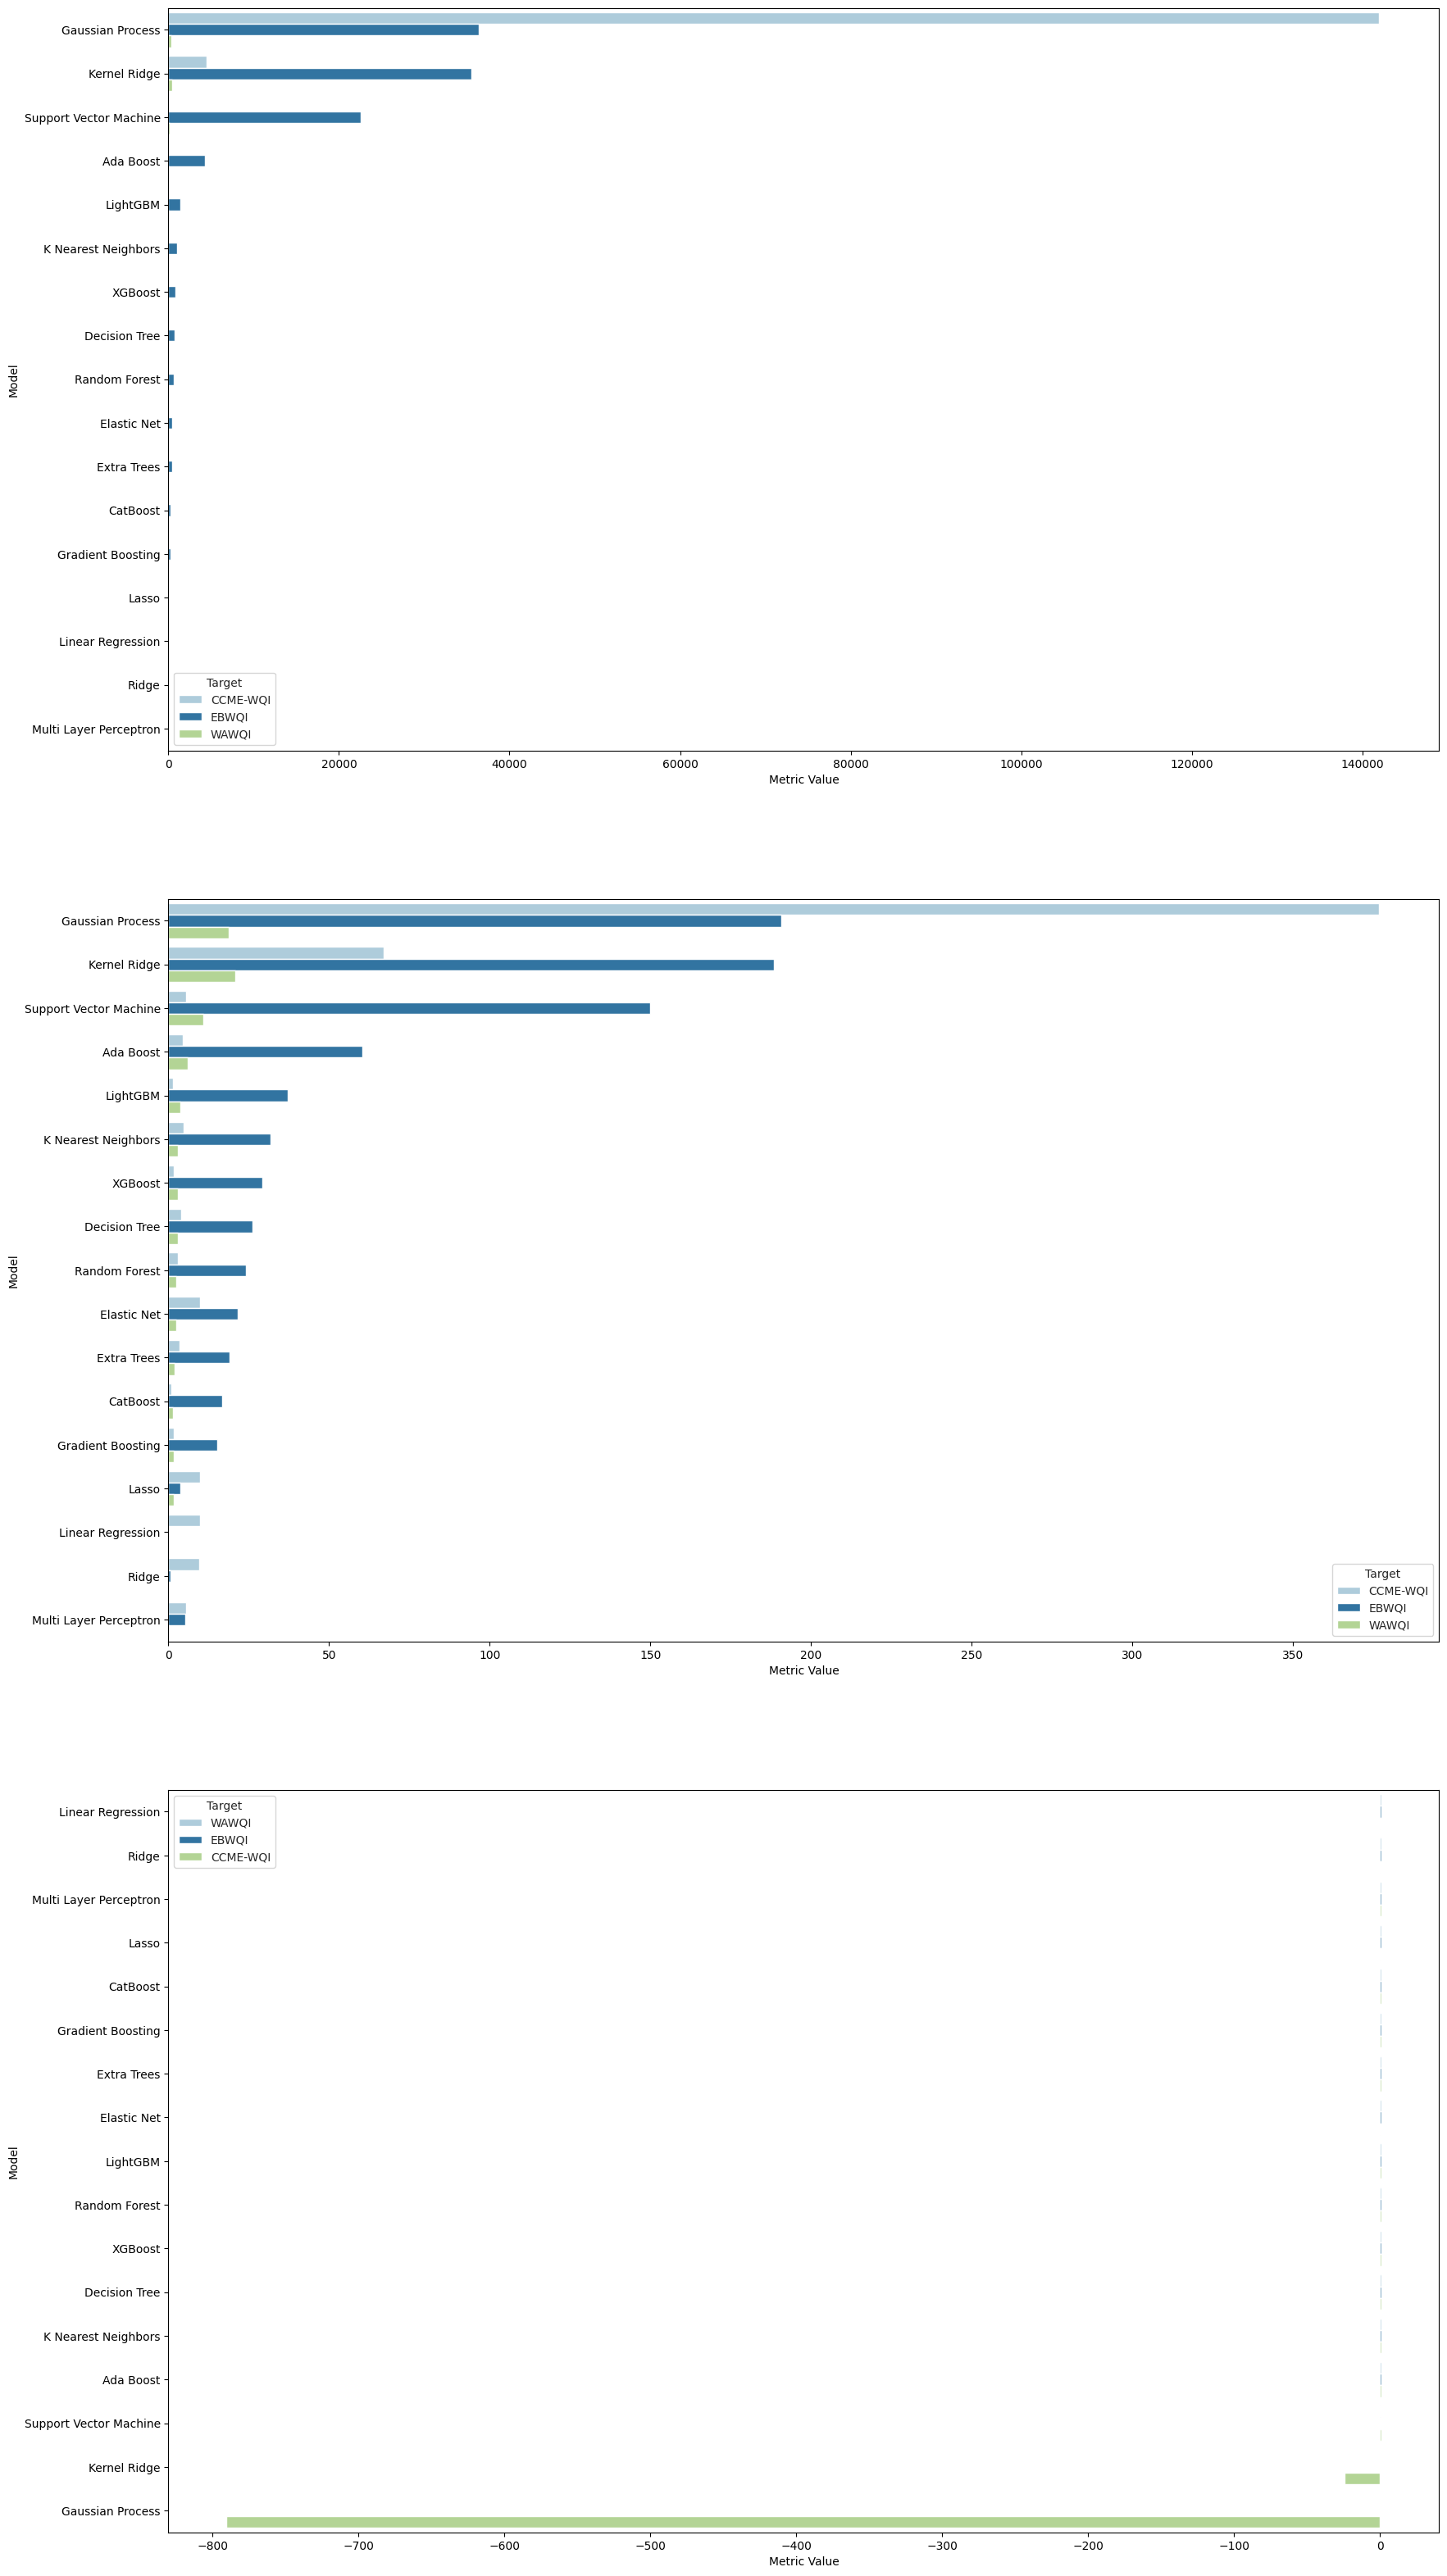

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(20, 40))
sns.set_style('whitegrid')
sns.set_palette('Paired')
for ax, metric in zip(axes.flatten(), ['MSE','RMSE','R2']):
    sns.barplot(data=regression_results_df[regression_results_df['Metric'] == metric].sort_values(by="Metric Value", ascending=False), x='Metric Value', y='Model', hue='Target', ax=ax, orient='h', palette='Paired')

In [61]:
regression_results_df[regression_results_df['Metric'] == 'R2'].sort_values(by='Metric Value', ascending=False).head(10)

,Model,Target,Metric,Metric Value,y_test,y_pred
3,Linear Regression,WAWQI,R2,1.000000,472 53.659444 2531 18.042417 23 12...,"[53.6594444444444, 18.04241666666667, 12.51188..."
8,Linear Regression,EBWQI,R2,1.000000,472 537.320129 2531 163.885568 23 ...,"[537.3201289016928, 163.88556808494442, 101.60..."
23,Ridge,EBWQI,R2,0.999987,472 537.320129 2531 163.885568 23 ...,"[537.2795404009314, 163.90318689684258, 101.60..."
18,Ridge,WAWQI,R2,0.999982,472 53.659444 2531 18.042417 23 12...,"[53.6534843566787, 18.040929810696777, 12.5120..."
243,Multi Layer Perceptron,WAWQI,R2,0.999835,472 53.659444 2531 18.042417 23 12...,"[53.52828059976647, 18.514425249186598, 12.362..."
38,Lasso,EBWQI,R2,0.999678,472 537.320129 2531 163.885568 23 ...,"[536.0696690356424, 164.98173151635086, 102.08..."
248,Multi Layer Perceptron,EBWQI,R2,0.999384,472 537.320129 2531 163.885568 23 ...,"[531.5724278472393, 176.15114654381077, 95.816..."
223,CatBoost,CCME-WQI,R2,0.995815,472 35.659063 2531 58.579592 23 71...,"[36.43413667380588, 59.020946936194356, 70.771..."
128,Gradient Boosting,EBWQI,R2,0.994283,472 537.320129 2531 163.885568 23 ...,"[525.8887356440375, 168.32914036140656, 97.446..."
213,CatBoost,WAWQI,R2,0.993983,472 53.659444 2531 18.042417 23 12...,"[53.13486724641226, 17.561105224879935, 12.595..."


In [62]:
regression_results_df[regression_results_df['Metric'] == 'MSE'].sort_values(by='Metric Value', ascending=True).head(10)

,Model,Target,Metric,Metric Value,y_test,y_pred
0,Linear Regression,WAWQI,MSE,7.830248e-28,472 53.659444 2531 18.042417 23 12...,"[53.6594444444444, 18.04241666666667, 12.51188..."
5,Linear Regression,EBWQI,MSE,2.814019e-26,472 537.320129 2531 163.885568 23 ...,"[537.3201289016928, 163.88556808494442, 101.60..."
15,Ridge,WAWQI,MSE,6.897113e-03,472 53.659444 2531 18.042417 23 12...,"[53.6534843566787, 18.040929810696777, 12.5120..."
240,Multi Layer Perceptron,WAWQI,MSE,3.923525e-02,472 53.659444 2531 18.042417 23 12...,"[53.502167423310546, 18.366876202191662, 12.55..."
20,Ridge,EBWQI,MSE,5.340165e-01,472 537.320129 2531 163.885568 23 ...,"[537.2795404009314, 163.90318689684258, 101.60..."
220,CatBoost,CCME-WQI,MSE,7.502265e-01,472 35.659063 2531 58.579592 23 71...,"[36.43413667380588, 59.020946936194356, 70.771..."
235,LightGBM,CCME-WQI,MSE,2.100659e+00,472 35.659063 2531 58.579592 23 71...,"[36.3592714659094, 60.42678405989161, 70.66235..."
210,CatBoost,WAWQI,MSE,2.301330e+00,472 53.659444 2531 18.042417 23 12...,"[53.13486724641226, 17.561105224879935, 12.595..."
120,Gradient Boosting,WAWQI,MSE,2.695466e+00,472 53.659444 2531 18.042417 23 12...,"[53.238201841454305, 18.59436661533354, 12.128..."
130,Gradient Boosting,CCME-WQI,MSE,2.967943e+00,472 35.659063 2531 58.579592 23 71...,"[35.98441005722067, 61.614568332086904, 70.805..."


### Regression Results

In [63]:
regression_df = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost','LightGBM','Random Forest']) ) & (regression_results_df['Metric'] == 'R2')][['Model','Target','Metric','Metric Value']].pivot(index='Model', columns='Target', values='Metric Value')
# create a mean column
regression_df['Mean'] = regression_df.mean(axis=1)
# sort the DataFrame by the mean column
regression_df = regression_df.sort_values(by='Mean', ascending=False)
regression_df.style.background_gradient(cmap='Greens', axis=None)

Target,CCME-WQI,EBWQI,WAWQI,Mean
Model,,,,
CatBoost,0.995815,0.993301,0.993983,0.994366
XGBoost,0.983173,0.979260,0.978527,0.980320
Random Forest,0.952531,0.986692,0.985546,0.974923
LightGBM,0.988281,0.966485,0.962039,0.972268
Linear Regression,0.471251,1.000000,1.000000,0.823750


### CatBoost, XGBoost and RandomForest are the best Models

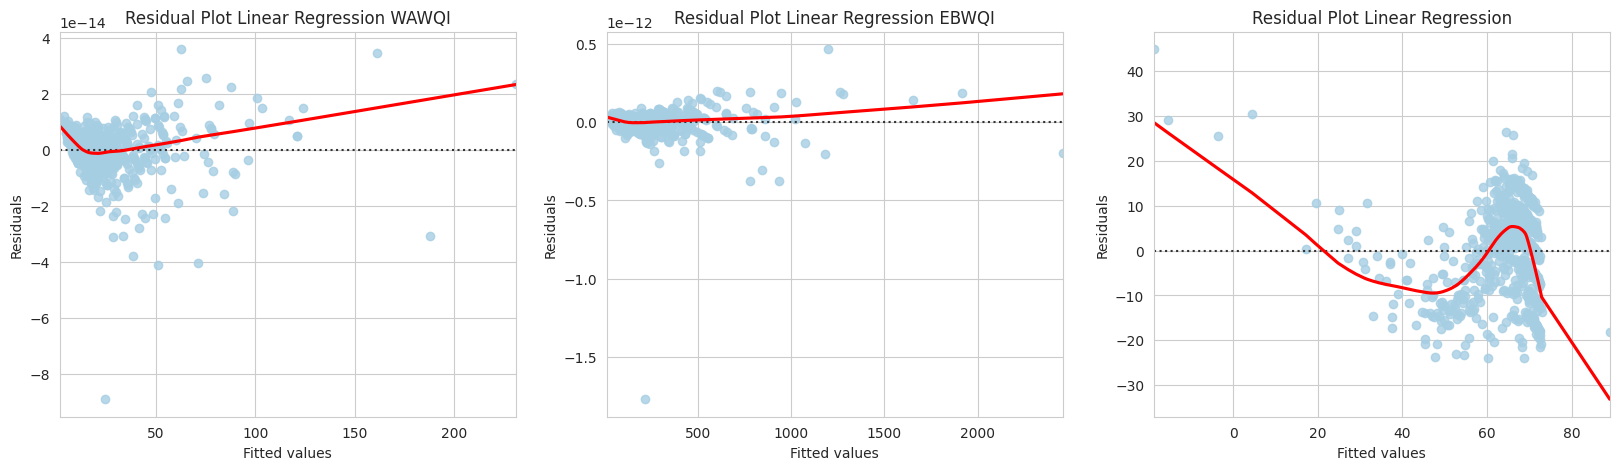

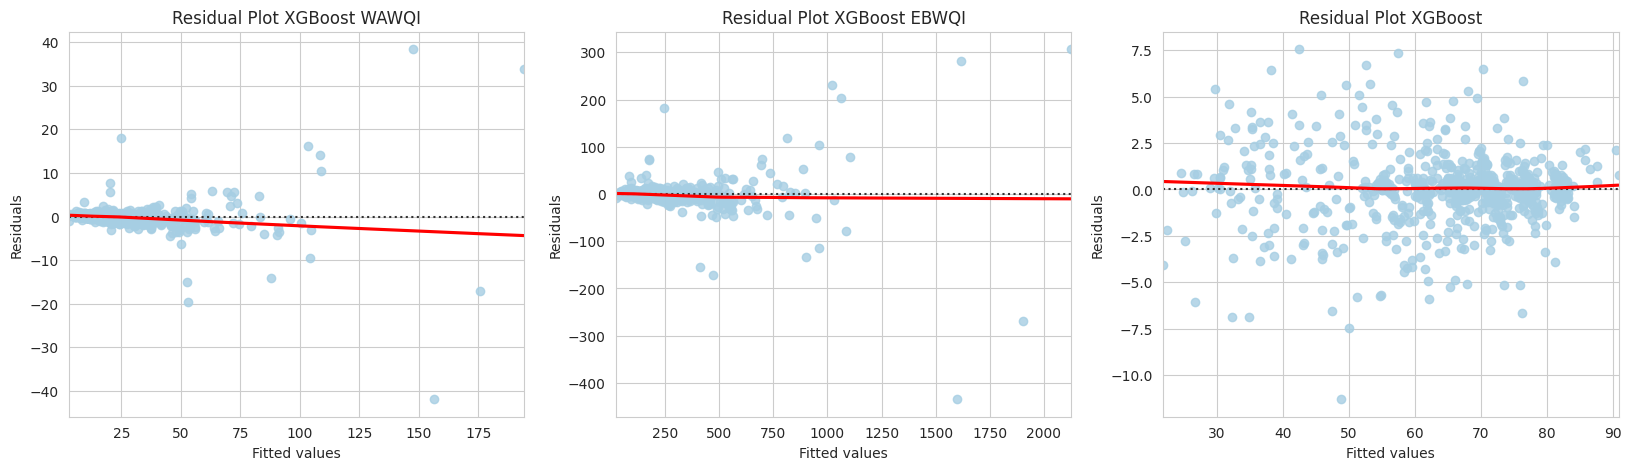

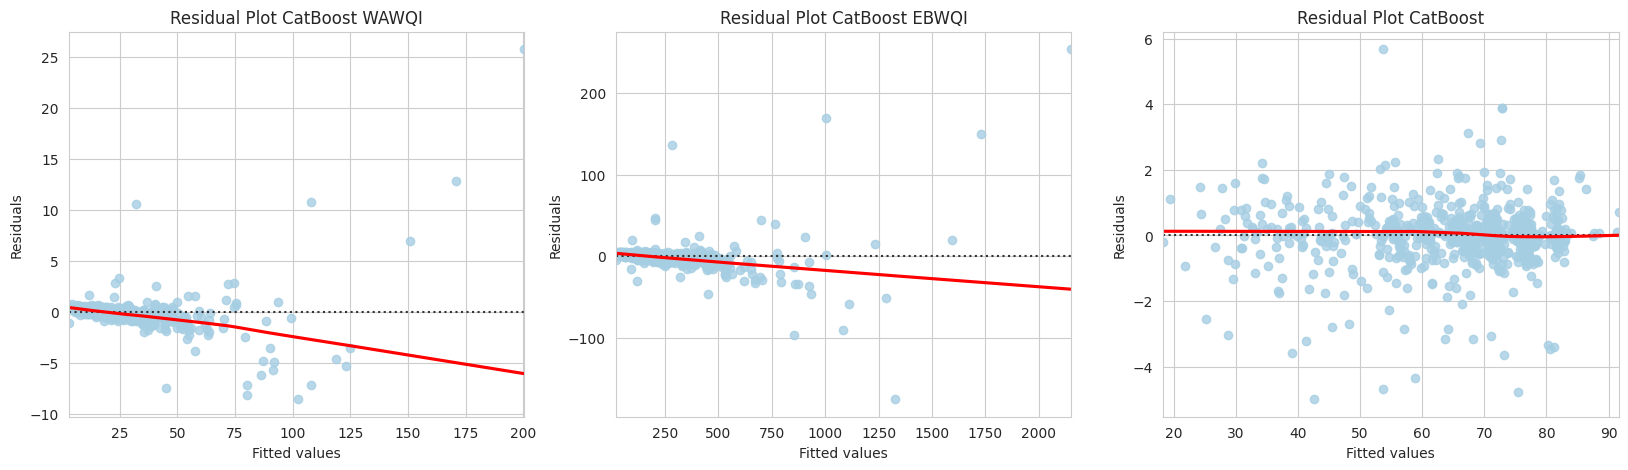

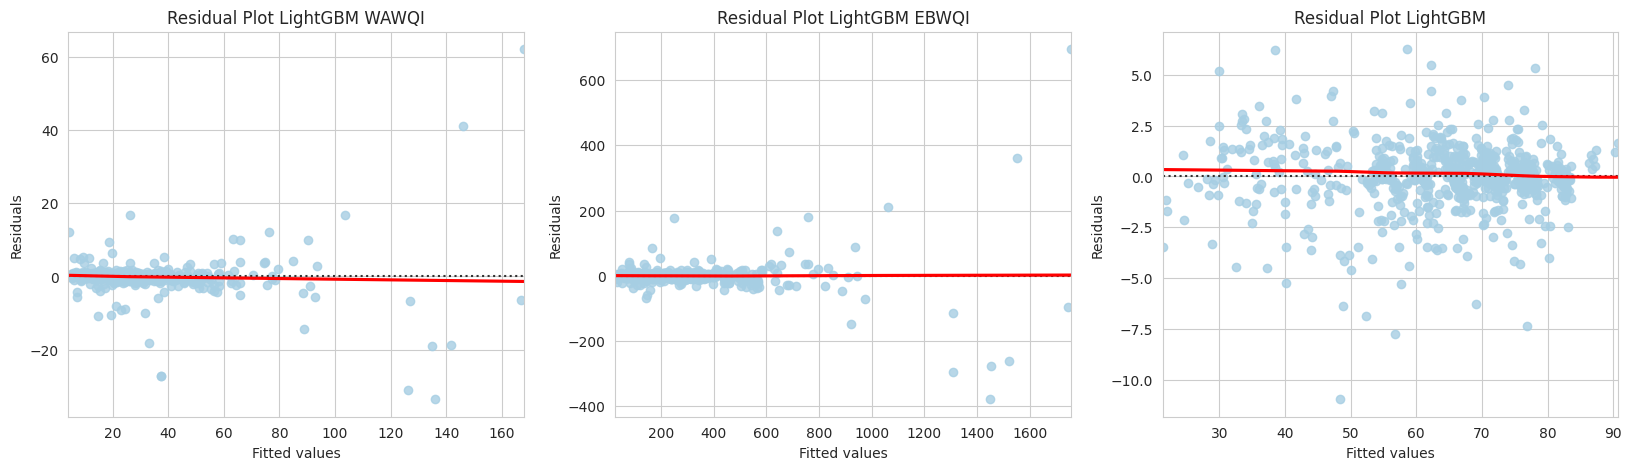

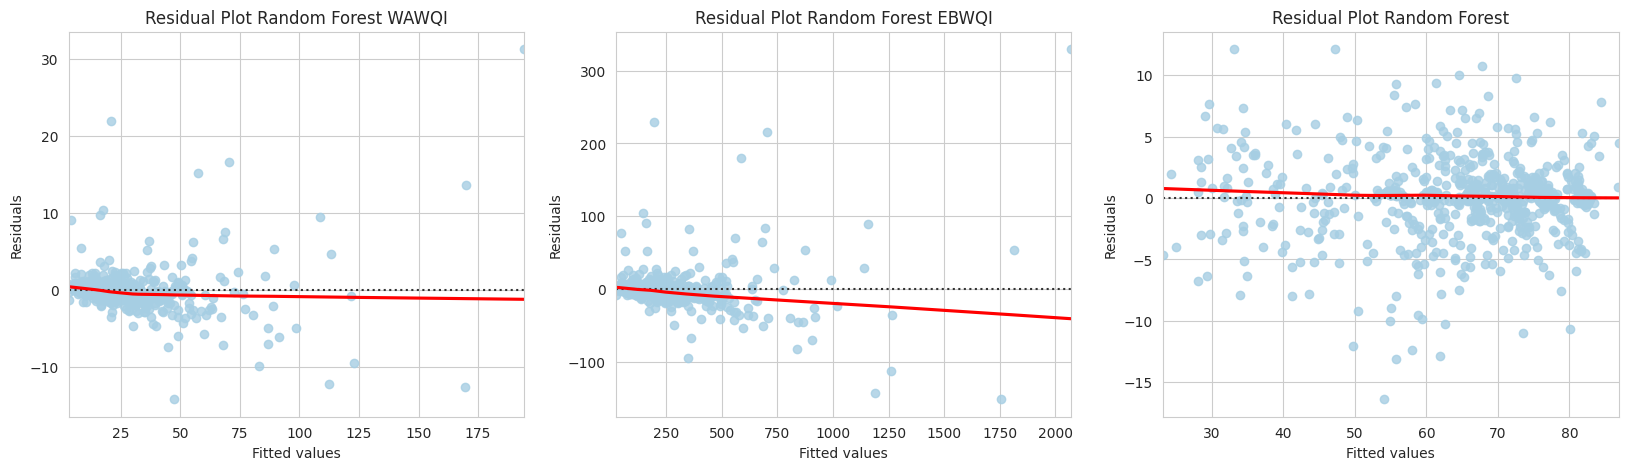

In [64]:
for model in ['Linear Regression', 'XGBoost', 'CatBoost', 'LightGBM', 'Random Forest']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, target in zip(axes.flatten(), ['WAWQI', 'EBWQI', 'CCME-WQI']):
        resid_plot_df = regression_results_df[(regression_results_df['Model'] == model) & (regression_results_df['Metric'] == 'R2') & (regression_results_df['Target'] == target)]
        resid_plot_df['residuals'] = resid_plot_df['y_test'] - resid_plot_df['y_pred']
        sns.residplot(x=resid_plot_df['y_pred'].values[0], y=resid_plot_df['residuals'].values[0].values, lowess=True, line_kws={'color': 'red'}, ax=ax)
        ax.set_xlabel("Fitted values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot {model} {resid_plot_df['Target'].values[0]}")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot {model}")

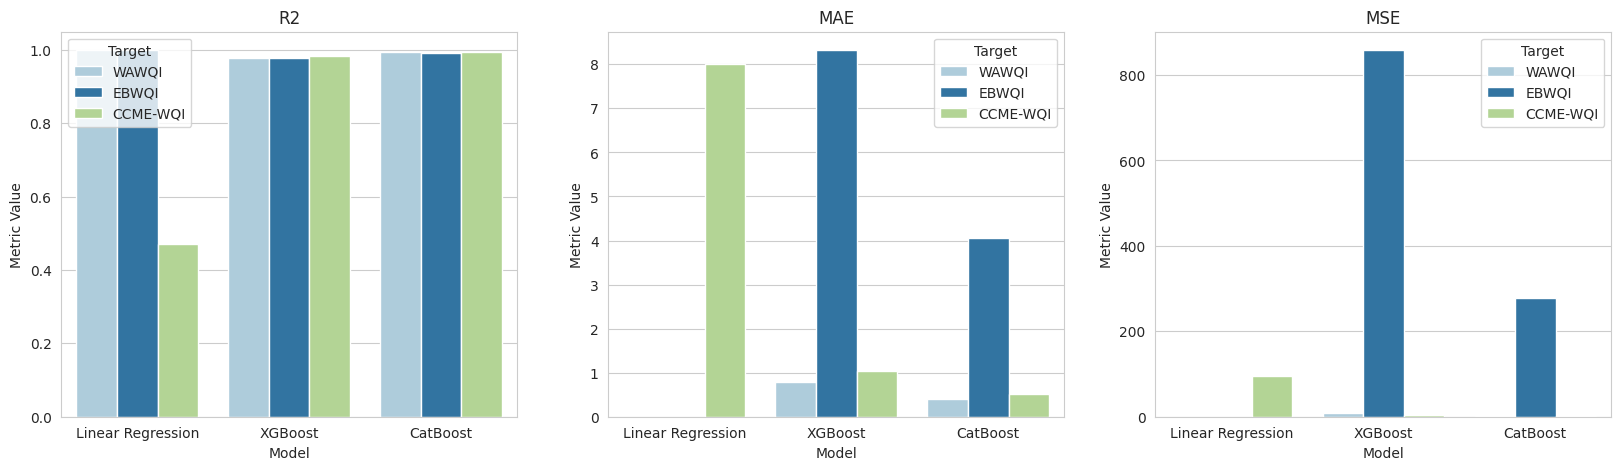

In [65]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

i = 0
ax = axes.flatten()
for metric in ['R2','MAE','MSE']:
        regression_results_df_tmp = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost'])) & (regression_results_df['Metric'] == metric)]
        sns.barplot(data=regression_results_df_tmp, x='Model', y='Metric Value', hue='Target', ax=ax[i])
        ax[i].set_title(f'{metric}')
        i+=1

## Classification

In [66]:
wqi

,PH,EC,ALK,SO4,CO3,F,MG,HCO3,TDS,NO3,TH,CL,NA,CA,K,CCME-WQI,WAWQI,EBWQI
0,7.69,4781.0,1100.0,270.0,0.0,3.25,48.0,1342.0,3203.0,17.00,300.0,780.0,1020.0,40.0,0.4,61.555420,38.644111,322.953062
1,7.56,790.0,290.0,36.0,0.0,2.20,10.0,354.0,529.0,12.00,100.0,43.0,140.0,24.0,17.2,64.601738,8.988333,68.551642
2,7.90,2550.0,640.0,10.0,0.0,0.25,72.0,781.0,1709.0,16.00,370.0,461.0,416.0,28.0,37.0,69.023569,22.555222,187.772599
3,7.80,1492.0,360.0,15.0,0.0,1.75,31.0,439.0,1000.0,17.00,210.0,191.0,210.0,32.0,5.2,76.746451,14.035111,115.300810
4,7.73,14520.0,1010.0,439.0,0.0,3.10,216.0,1232.0,9728.0,45.00,1350.0,4361.0,2940.0,180.0,33.0,29.843938,103.398000,1038.036172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,7.42,768.0,150.0,70.0,0.0,0.15,19.0,183.0,515.0,3.20,180.0,113.0,95.0,40.0,10.0,60.989717,7.274778,60.166415
4562,7.73,4419.0,330.0,310.0,0.0,0.78,112.0,403.0,2961.0,13.00,701.0,1064.0,712.0,96.0,17.0,57.180425,34.582556,331.010335
4563,7.60,2942.0,230.0,538.0,0.0,0.93,17.0,281.0,1971.0,33.00,400.0,567.0,552.0,132.0,26.0,75.149894,23.527667,217.290519
4564,7.35,1464.0,500.0,25.0,0.0,1.04,36.0,610.0,981.0,0.31,410.0,142.0,125.0,104.0,18.0,87.842858,15.582556,119.304083


In [67]:
def create_categorical_wqi(df):
    df['WAWQI_classif'] = df['WAWQI'].apply(lambda x: 'Undrinkable' if x >= 100 else ('Very Poor' if x >= 76 else ('Poor' if x >= 51 else ('Good' if x >= 26 else 'Excellent'))))
    df['WAWQI_encoded'] = df['WAWQI'].apply(lambda x: 0 if x >= 100 else (1 if x >= 76 else (2 if x >= 51 else (3 if x >= 26 else 4))))

    df['EBWQI_classif'] = df['EBWQI'].apply(lambda x: 'Undrinkable' if x >= 100 else ('Very Poor' if x >= 76 else ('Poor' if x >= 51 else ('Good' if x >= 26 else 'Excellent'))))
    df['EBWQI_encoded'] = df['EBWQI'].apply(lambda x: 0 if x >= 100 else (1 if x >= 76 else (2 if x >= 51 else (3 if x >= 26 else 4))))

    df['CCME-WQI_classif'] = df['CCME-WQI'].apply(lambda x: 'Excellent' if x >= 95 else ('Good' if x >= 80 else ('Fair' if x >= 65 else ('Marginal' if x >= 45 else 'Poor'))))
    df['CCME-WQI_encoded'] = df['CCME-WQI'].apply(lambda x: 4 if x >= 95 else (3 if x >= 80 else (2 if x >= 65 else (1 if x >= 45 else 1))))

create_categorical_wqi(wqi)

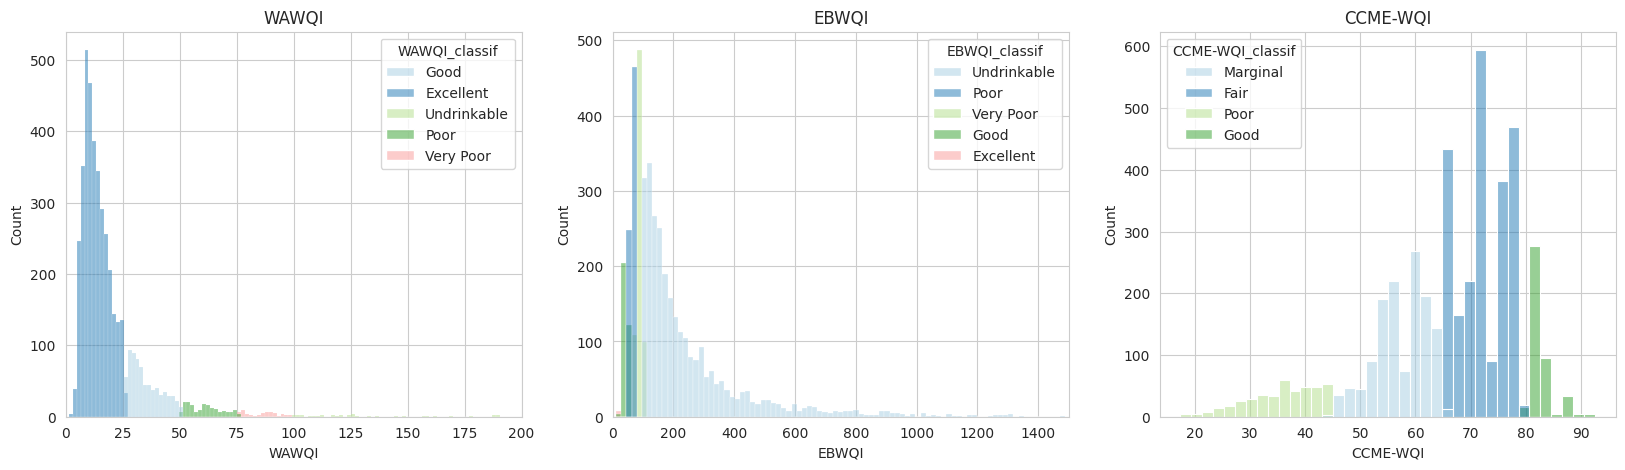

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, col in enumerate(['WAWQI','EBWQI','CCME-WQI']):
    sns.histplot(data=wqi, x=col, hue=col+'_classif', ax=ax[i])
    ax[i].set_title(col)
    if (col=='WAWQI'):
        ax[i].set_xlim(0, 200)
    if (col=='EBWQI'):
        ax[i].set_xlim(0, 1500)
    ax[i].set_xlim()

In [69]:
wqi

,PH,EC,ALK,SO4,CO3,F,MG,HCO3,TDS,NO3,...,K,CCME-WQI,WAWQI,EBWQI,WAWQI_classif,WAWQI_encoded,EBWQI_classif,EBWQI_encoded,CCME-WQI_classif,CCME-WQI_encoded
0,7.69,4781.0,1100.0,270.0,0.0,3.25,48.0,1342.0,3203.0,17.00,...,0.4,61.555420,38.644111,322.953062,Good,3,Undrinkable,0,Marginal,1
1,7.56,790.0,290.0,36.0,0.0,2.20,10.0,354.0,529.0,12.00,...,17.2,64.601738,8.988333,68.551642,Excellent,4,Poor,2,Marginal,1
2,7.90,2550.0,640.0,10.0,0.0,0.25,72.0,781.0,1709.0,16.00,...,37.0,69.023569,22.555222,187.772599,Excellent,4,Undrinkable,0,Fair,2
3,7.80,1492.0,360.0,15.0,0.0,1.75,31.0,439.0,1000.0,17.00,...,5.2,76.746451,14.035111,115.300810,Excellent,4,Undrinkable,0,Fair,2
4,7.73,14520.0,1010.0,439.0,0.0,3.10,216.0,1232.0,9728.0,45.00,...,33.0,29.843938,103.398000,1038.036172,Undrinkable,0,Undrinkable,0,Poor,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,7.42,768.0,150.0,70.0,0.0,0.15,19.0,183.0,515.0,3.20,...,10.0,60.989717,7.274778,60.166415,Excellent,4,Poor,2,Marginal,1
4562,7.73,4419.0,330.0,310.0,0.0,0.78,112.0,403.0,2961.0,13.00,...,17.0,57.180425,34.582556,331.010335,Good,3,Undrinkable,0,Marginal,1
4563,7.60,2942.0,230.0,538.0,0.0,0.93,17.0,281.0,1971.0,33.00,...,26.0,75.149894,23.527667,217.290519,Excellent,4,Undrinkable,0,Fair,2
4564,7.35,1464.0,500.0,25.0,0.0,1.04,36.0,610.0,981.0,0.31,...,18.0,87.842858,15.582556,119.304083,Excellent,4,Undrinkable,0,Good,3


In [70]:
# create similar code just for classification
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

X = wqi.drop(['WAWQI', 'EBWQI', 'CCME-WQI', 'WAWQI_classif','EBWQI_classif','CCME-WQI_classif','WAWQI_encoded','EBWQI_encoded','CCME-WQI_encoded'], axis=1)
X = StandardScaler().fit_transform(X)

y1 = wqi['WAWQI_encoded']
y2 = wqi['EBWQI_encoded']
y3 = wqi['CCME-WQI_encoded']

X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

class_list = [0,1,2,3,4]

class_count_1 = y1_test.value_counts().values
class_count_2 = y2_test.value_counts().values
class_count_3 = y3_test.value_counts().values

class_weights_1 = compute_class_weight(class_weight='balanced', classes=np.unique(y1), y=y1)
class_weights_2 = compute_class_weight(class_weight='balanced', classes=np.unique(y2), y=y2)
class_weights_3 = compute_class_weight(class_weight='balanced', classes=np.unique(y3), y=y3)

class_weights_dict_1 = {class_label: weight for class_label, weight in zip(class_list, class_weights_1)}
class_weights_dict_2 = {class_label: weight for class_label, weight in zip(class_list, class_weights_2)}
class_weights_dict_3 = {class_label: weight for class_label, weight in zip(class_list, class_weights_3)}

# create a dictionary for model names and model object for multi class classification
models_multi = {
    'Random Forest': [
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=100, random_state=42)
        ],
    'XGBoost': [
        XGBClassifier(objective='multi:softmax', num_class=5, random_state=42),
        XGBClassifier(objective='multi:softmax', num_class=5, random_state=42),
        XGBClassifier(objective='multi:softmax', num_class=5, random_state=42),
        # XGBClassifier(objective='multi:softmax'),
        # XGBClassifier(objective='multi:softmax'),
        # XGBClassifier(objective='multi:softmax')
        ],
    'CatBoost': [
        CatBoostClassifier(iterations=100, random_state=42, verbose=False),
        CatBoostClassifier(iterations=100, random_state=42, verbose=False),
        CatBoostClassifier(iterations=100, random_state=42, verbose=False),
        ],
    'LightGBM': [
        LGBMClassifier(objective='multiclass', num_class=5, random_state=42),
        LGBMClassifier(objective='multiclass', num_class=5, random_state=42),
        LGBMClassifier(objective='multiclass', num_class=5, random_state=42),
        ],
    # 'Multi Layer Perceptron': MLPClassifier()
}

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, \
    confusion_matrix, log_loss, matthews_corrcoef, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Create a dictionary to store results
results_dict = {'Model': [], 'Target': [], 'Metric': [], 'Metric Value': [], 'proba': [], 'y_train': [], 'y_test': []}

# create a list of metrics for classification
metrics = {
    # 'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score,
    # 'Cohen\'s Kappa': cohen_kappa_score,
    # 'Confusion Matrix': confusion_matrix,
    # 'Log Loss': log_loss,
    # 'Matthews Correlation Coefficient': matthews_corrcoef,
    # 'ROC AUC Score': roc_auc_score
}

# Loop through models
for name, model in tqdm(models_multi.items()):
    for target_name, target_train, target_test in [('WAWQI', y1_train, y1_test), ('EBWQI', y2_train, y2_test), ('CCME-WQI', y3_train, y3_test)]:
        for metric_name, metric_func in metrics.items():
            # Train the model
            if (target_name=='WAWQI'):
                model1 = model[0]
            elif (target_name=='EBWQI'):
                model1 = model[1]
            else:
                model1 = model[2]
            
            print(f"{name} - {target_name} - {metric_name}")

            if name == 'XGBoost' and target_name == 'CCME-WQI':
                le = LabelEncoder()

                # copy the target variable
                target_train_xgb = target_train.copy()
                target_test_xgb = target_test.copy()

                # replace 1,2,3 with 0,1,2
                target_train_xgb[target_train_xgb == 1] = 0
                target_train_xgb[target_train_xgb == 2] = 1
                target_train_xgb[target_train_xgb == 3] = 2

                target_test_xgb[target_test_xgb == 1] = 0
                target_test_xgb[target_test_xgb == 2] = 1
                target_test_xgb[target_test_xgb == 3] = 2

                model1.fit(X_train, target_train_xgb)
                y_pred_1 = model1.predict(X_test)
                y_proba = model1.predict_proba(X_test)

                metric_value_1 = metric_func(target_test_xgb, y_pred_1, average='macro')

                # Store results in the dictionary
                results_dict['Model'].append(name)
                results_dict['Target'].append(target_name)
                results_dict['Metric'].append(metric_name)
                results_dict['Metric Value'].append(metric_value_1)
                results_dict['proba'].append(y_proba)
                results_dict['y_train'].append(target_train_xgb.values)
                results_dict['y_test'].append(target_test_xgb.values)
                continue

            # for other models
            model1.fit(X_train, target_train)
            y_pred_1 = model1.predict(X_test)
            y_proba = model1.predict_proba(X_test)

            metric_value_1 = metric_func(target_test, y_pred_1, average='macro')

            # Store results in the dictionary
            results_dict['Model'].append(name)
            results_dict['Target'].append(target_name)
            results_dict['Metric'].append(metric_name)
            results_dict['Metric Value'].append(metric_value_1)
            results_dict['proba'].append(y_proba)
            results_dict['y_train'].append(target_train.values)
            results_dict['y_test'].append(target_test.values)

  0%|          | 0/4 [00:00<?, ?it/s]

Random Forest - WAWQI - Precision
Random Forest - WAWQI - Recall
Random Forest - WAWQI - F1 Score
Random Forest - EBWQI - Precision
Random Forest - EBWQI - Recall
Random Forest - EBWQI - F1 Score
Random Forest - CCME-WQI - Precision
Random Forest - CCME-WQI - Recall
Random Forest - CCME-WQI - F1 Score


 25%|██▌       | 1/4 [00:01<00:05,  1.90s/it]

XGBoost - WAWQI - Precision
XGBoost - WAWQI - Recall
XGBoost - WAWQI - F1 Score
XGBoost - EBWQI - Precision
XGBoost - EBWQI - Recall
XGBoost - EBWQI - F1 Score
XGBoost - CCME-WQI - Precision
XGBoost - CCME-WQI - Recall


 50%|█████     | 2/4 [00:03<00:03,  1.55s/it]

XGBoost - CCME-WQI - F1 Score
CatBoost - WAWQI - Precision
CatBoost - WAWQI - Recall
CatBoost - WAWQI - F1 Score
CatBoost - EBWQI - Precision
CatBoost - EBWQI - Recall
CatBoost - EBWQI - F1 Score
CatBoost - CCME-WQI - Precision
CatBoost - CCME-WQI - Recall
CatBoost - CCME-WQI - F1 Score


 75%|███████▌  | 3/4 [00:05<00:02,  2.01s/it]

LightGBM - WAWQI - Precision
LightGBM - WAWQI - Recall
LightGBM - WAWQI - F1 Score
LightGBM - EBWQI - Precision
LightGBM - EBWQI - Recall
LightGBM - EBWQI - F1 Score
LightGBM - CCME-WQI - Precision
LightGBM - CCME-WQI - Recall
LightGBM - CCME-WQI - F1 Score


100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


In [ ]:
# Create a DataFrame
df_classif = pd.DataFrame(results_dict)

# Print the DataFrame
df_classif

,Model,Target,Metric,Metric Value,proba,y_train,y_test
0,Random Forest,WAWQI,Precision,0.888781,"[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0....","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."
1,Random Forest,WAWQI,Recall,0.867051,"[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0....","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."
2,Random Forest,WAWQI,F1 Score,0.848676,"[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0....","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."
3,Random Forest,EBWQI,Precision,0.879346,"[[0.77, 0.23, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, ...","[3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...","[0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ..."
4,Random Forest,EBWQI,Recall,0.881530,"[[0.77, 0.23, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, ...","[3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...","[0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ..."
5,Random Forest,EBWQI,F1 Score,0.880027,"[[0.77, 0.23, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, ...","[3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...","[0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ..."
6,Random Forest,CCME-WQI,Precision,0.886311,"[[0.0, 0.9, 0.1], [0.31, 0.49, 0.2], [0.9, 0.1...","[1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...","[2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ..."
7,Random Forest,CCME-WQI,Recall,0.797756,"[[0.0, 0.9, 0.1], [0.31, 0.49, 0.2], [0.9, 0.1...","[1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...","[2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ..."
8,Random Forest,CCME-WQI,F1 Score,0.828169,"[[0.0, 0.9, 0.1], [0.31, 0.49, 0.2], [0.9, 0.1...","[1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...","[2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ..."
9,XGBoost,WAWQI,Precision,0.888781,"[[5.894912e-05, 8.637794e-06, 1.3630979e-05, 7...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."


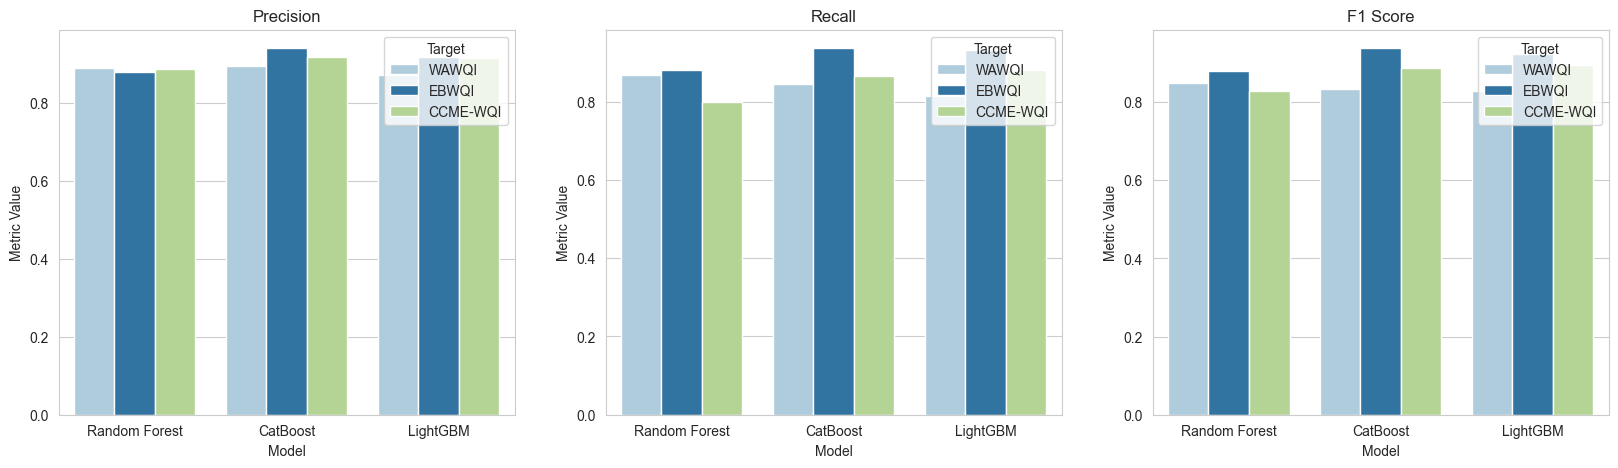

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

i = 0
ax = axes.flatten()
for metric in ['Precision','Recall','F1 Score']:
        df_filtered = df_classif[(df_classif['Model'].isin(['LightGBM','Random Forest','CatBoost'])) & (df_classif['Metric'] == metric)]
        sns.barplot(data=df_filtered, x='Model', y='Metric Value', hue='Target', ax=ax[i])
        ax[i].set_title(f'{metric}')
        i+=1

In [ ]:
for model in ['LightGBM', 'Random Forest', 'CatBoost', 'XGBoost']:
    print(df_classif[(df_classif['Model'] == model) & (df_classif['Metric'] == 'F1 Score')])

       Model    Target    Metric  Metric Value  \
29  LightGBM     WAWQI  F1 Score      0.829621   
32  LightGBM     EBWQI  F1 Score      0.923873   
35  LightGBM  CCME-WQI  F1 Score      0.896022   

                                                proba  \
29  [[1.3497254820220738e-08, 1.273357314291218e-0...   
32  [[0.9963817909886006, 0.0036138669301777524, 3...   
35  [[0.00010525252405354131, 0.999678696514988, 0...   

                                              y_train  \
29  [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...   
32  [3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...   
35  [1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...   

                                               y_test  
29  [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ...  
32  [0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...  
35  [2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ...  
           Model    Target    Metric  Metric Value  \
2  Random Forest     WAWQI  F1 Score      0.848676   
5  Random

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def plot_roc(y_test, y_score):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

for model in ['LightGBM', 'Random Forest', 'CatBoost', 'XGBoost']:
    df = df_classif[(df_classif['Model'] == model) & (df_classif['Metric'] == 'F1 Score')]

    label_binarizer = LabelBinarizer().fit(df['y_train'].values[0])
    y_onehot_test = label_binarizer.transform(df['y_test'].values[0])

    for class_of_interest in range(0,5):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        plot_roc(y_onehot_test[:, class_id], df['proba'].values[0][:, class_id])


## :sparkles: Best Models:
### Regression: CatBoost

# :sparkles: Hyperparameter Tuning

In [71]:
X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

# Regression
y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

# Train test split
X_train_reg, X_test_reg, y1_train_reg, y1_test_reg, y2_train_reg, y2_test_reg, y3_train_reg, y3_test_reg = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

In [78]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split


# catboost objective
def catboost_objective(trial, y_train_reg, y_test_reg):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        # Add more parameters as needed
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_reg, y_train_reg, verbose=False)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test_reg, y_pred)

    return accuracy

def xgboost_objective(trial, y_train_reg, y_test_reg):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 100),
        # Add more parameters as needed
    }

    model = XGBClassifier(**params)
    model.fit(X_train_reg, y_train_reg, verbose=False)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test_reg, y_pred)

    return accuracy

# RandomForest objective
def randomforest_objective(trial, y_train_reg, y_test_reg):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        # Add more parameters as needed
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train_reg, y_train_reg)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test_reg, y_pred)

    return accuracy

In [79]:
from functools import partial

def optimize_catboost():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(catboost_objective, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

def optimize_xgboost():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(xgboost_objective, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

def optimize_randomforest():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(optimize_randomforest, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

In [80]:
best_params_catboost = optimize_catboost()

[I 2024-05-11 10:13:15,866] A new study created in memory with name: no-name-993d5e25-6f0d-497a-afed-0b260e02c4ef
